In [1]:
from google.colab import drive
drive.mount("/content/drive")

from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving dga_data_full.csv to dga_data_full.csv


In [2]:
import math
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import joblib

In [3]:
def shannon_entropy(domain):
  freq_dict = Counter(domain)

  entropy = 0
  for c, f in freq_dict.items():
    p = f / len(domain)
    entropy += p * math.log2(p)

  return -entropy

def vowel_to_consonant_ratio(domain):
  vowels = 0
  consonants = 0

  for c in domain:
    if c in {'a', 'e', 'i', 'o', 'u'}:
      vowels += 1
    else:
      consonants += 1

  return vowels / consonants

def max_consecutive_consonant(domain):
  mx = 0

  i = 0
  while i < len(domain):
    while i < len(domain) and domain[i] in {'a', 'e', 'i', 'o', 'u'}:
      i += 1

    j = i + 1
    while j < len(domain) and domain[j] not in {'a', 'e', 'i', 'o', 'u'}:
      j += 1

    mx = max(mx, j - i)
    i = j

  return mx

def unique_characters(domain):
  st = set()

  for c in domain:
    st.add(c)

  return len(st)

tokens = {}
for i in range(1, 1 + 10):
  tokens[chr(i - 1 + ord('0'))] = i;

for i in range(11, 11 + 26, 1):
  tokens[chr(i - 11 + ord('a'))] = i

tokens["PAD"] = 0
tokens['.'] = 37

def tokenize(domain):
  encoded = []

  for c in domain:
    if c in tokens:
      encoded.append(tokens[c])

  return encoded

def clean_domain(domain):
  return "".join(c for c in domain.lower() if c.isalnum())

vectorizer = joblib.load("/content/drive/My Drive/dga_models/vectorizer.joblib")
log10_count = np.load("/content/drive/My Drive/dga_models/log10_count.npy")

In [4]:
df = pd.read_csv("dga_data_full.csv")

df = df.drop(columns=["domain", "subclass"])
df = df.rename(columns={"host": "domain"})
df["domain"] = df["domain"].str.replace(r"\s+", "", regex=True)
df["isDGA"] = (df["isDGA"] == "dga").astype(int)
df["domain_length"] = df["domain"].str.len()
df["shannon_entropy"] = df["domain"].apply(shannon_entropy)
df["vc_ratio"] = df["domain"].apply(vowel_to_consonant_ratio)
df["ngram_score"]= log10_count * vectorizer.transform(df["domain"]).T
df["mcc"] = df["domain"].apply(max_consecutive_consonant)
df["unique_chars"] = df["domain"].apply(unique_characters)
df["tokenize"] = df["domain"].apply(tokenize)

print(df)

        isDGA                          domain  domain_length  shannon_entropy  \
0           1  6xzxsw3sokvg1tc752y1a6p0af.com             30         4.440224   
1           1               glbtlxwwhbnpxs.ru             17         3.616875   
2           1               xxmamopyipbfpk.ru             17         3.572469   
3           1   zfd5szpi18i85wj9uy13l69rg.net             29         4.444188   
4           1                 jpqftymiuver.ru             15         3.640224   
...       ...                             ...            ...              ...   
159995      0                     manhunt.net             11         2.845351   
159996      0                      yupptv.com             10         3.121928   
159997      0                    bbcmundo.com             12         2.918296   
159998      0                   kanogames.com             13         3.238901   
159999      0                    roadrover.cn             12         3.022055   

        vc_ratio  ngram_sco

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokens
token_seqs = df["tokenize"].tolist()
X_tokens = pad_sequences(token_seqs, padding="post", value=0)

# Handcrafted features
handcrafted_cols = ["domain_length", "shannon_entropy", "vc_ratio", "ngram_score", "mcc", "unique_chars"]
X_features = df[handcrafted_cols].values.astype(np.float32)

# Labels
y = df["isDGA"].values.astype(np.int32)

In [6]:
print(X_tokens)
print(X_features)
print(y)

[[ 7 34 36 ...  0  0  0]
 [17 22 12 ...  0  0  0]
 [34 34 23 ...  0  0  0]
 ...
 [12 12 13 ...  0  0  0]
 [21 11 24 ...  0  0  0]
 [28 25 11 ...  0  0  0]]
[[3.0000000e+01 4.4402237e+00 1.5384616e-01 6.2933826e+01 1.1000000e+01
  2.3000000e+01]
 [1.7000000e+01 3.6168747e+00 6.2500000e-02 4.1578175e+01 1.6000000e+01
  1.3000000e+01]
 [1.7000000e+01 3.5724695e+00 3.0769232e-01 4.4070511e+01 7.0000000e+00
  1.3000000e+01]
 ...
 [1.2000000e+01 2.9182959e+00 3.3333334e-01 5.9604458e+01 4.0000000e+00
  8.0000000e+00]
 [1.3000000e+01 3.2389011e+00 6.2500000e-01 8.5190964e+01 3.0000000e+00
  1.0000000e+01]
 [1.2000000e+01 3.0220551e+00 5.0000000e-01 6.3870914e+01 4.0000000e+00
  9.0000000e+00]]
[1 1 1 ... 0 0 0]


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_gru_model(vocab_size: int = 38, embedding_dim: int = 128, hidden_dim: int = 256, n_layers: int = 2, dropout_rate: float = 0.5, num_features: int = 6) -> tf.keras.Model:
  token_input = tf.keras.Input(shape=(None,), dtype=tf.int32, name="token_input")
  feat_input  = tf.keras.Input(shape=(num_features,), dtype=tf.float32, name="handcrafted_features")

  x = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    mask_zero=True,
    name="embedding"
  )(token_input)
  x = layers.Dropout(dropout_rate, name="embed_dropout")(x)

  for i in range(n_layers):
    return_sequences = (i < n_layers - 1)
    x = layers.Bidirectional(
      layers.GRU(
        hidden_dim,
        return_sequences=return_sequences,
        dropout=dropout_rate,
        name=f"gru_layer_{i+1}"
      ),
      merge_mode="concat",
      name=f"bi_gru_{i+1}"
    )(x)

  x = layers.Dropout(dropout_rate, name="gru_output_dropout")(x)

  x = layers.Concatenate(name="concat_features")([x, feat_input])

  x = layers.Dense(256, activation="relu", name="dense_1")(x)
  x = layers.Dropout(dropout_rate, name="dropout_1")(x)
  x = layers.Dense(128, activation="relu", name="dense_2")(x)
  x = layers.Dropout(dropout_rate, name="dropout_2")(x)
  logits = layers.Dense(2, name="logits")(x)

  model = Model(inputs=[token_input, feat_input], outputs=logits, name="DGA_GRU_Model")
  model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
  )
  return model

keras_model = build_gru_model()
keras_model.summary()

Model: "DGA_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │      4,864 │ token_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dropout       │ (None, None, 128) │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ token_input[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru_1            │ (None, None, 512) │    592,896 │ embed_dropout[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru_2            │ (None, 512)       │  1,182,720 │ bi_gru_1[0][0],   │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_output_dropout  │ (None, 512)       │          0 │ bi_gru_2[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ handcrafted_featur… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 518)       │          0 │ gru_output_dropo… │
│ (Concatenate)       │                   │            │ handcrafted_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    132,864 │ concat_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,946,498 (7.43 MB)

 Trainable params: 1,946,498 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
X_tok_train, X_tok_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(X_tokens, X_features, y, test_size=0.2, random_state=42, stratify=y)

batch_size = 512

train_ds = tf.data.Dataset.from_tensor_slices(
  ((X_tok_train, X_feat_train), y_train)
).shuffle(buffer_size=len(X_tok_train)) \
 .batch(batch_size) \
 .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
  ((X_tok_test, X_feat_test), y_test)
).batch(batch_size) \
 .prefetch(tf.data.AUTOTUNE)

history = keras_model.fit(
  train_ds,
  epochs=10,
  validation_data=val_ds
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2473s 10s/step - accuracy: 0.8565 - loss: 0.4908 - val_accuracy: 0.9717 - val_loss: 0.0628
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2455s 10s/step - accuracy: 0.9696 - loss: 0.0758 - val_accuracy: 0.9790 - val_loss: 0.0544
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2458s 10s/step - accuracy: 0.9749 - loss: 0.0654 - val_accuracy: 0.9834 - val_loss: 0.0421
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2503s 10s/step - accuracy: 0.9815 - loss: 0.0500 - val_accuracy: 0.9842 - val_loss: 0.0396
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2461s 10s/step - accuracy: 0.9822 - loss: 0.0485 - val_accuracy: 0.9880 - val_loss: 0.0352
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2495s 10s/step - accuracy: 0.9854 - loss: 0.0401 - val_accuracy: 0.9886 - val_loss: 0.0312
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2458s 10s/step - accuracy: 0.9874 - loss: 0.0360 - val_accuracy: 0.9911 - val_loss: 0.0250
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2454s 10s/step - accuracy: 0.9883 - loss: 0

In [9]:
keras_model.save("model.keras")
keras_model.save("model.h5")

from google.colab import files
files.download("model.h5")
files.download("model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step
31754 / 32000 correct
True label counts: Counter({np.int32(0): 16000, np.int32(1): 16000})
Predicted counts : Counter({np.int64(1): 16066, np.int64(0): 15934})
              precision    recall  f1-score   support

     Non-DGA       0.99      0.99      0.99     16000
         DGA       0.99      0.99      0.99     16000

    accuracy                           0.99     32000
   macro avg       0.99      0.99      0.99     32000
weighted avg       0.99      0.99      0.99     32000



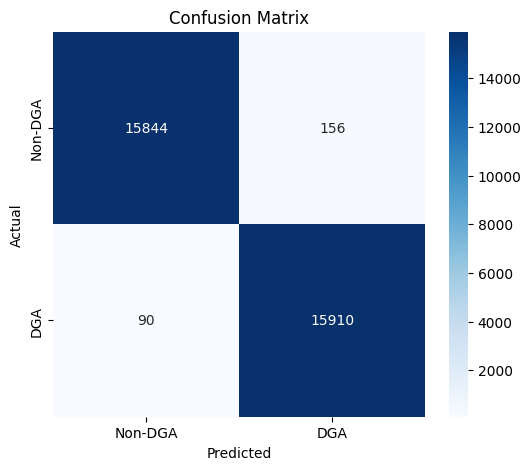

In [10]:
test_ds = val_ds
logits = keras_model.predict(test_ds)

preds = np.argmax(logits, axis=1)

y_true = np.concatenate([
  y_batch.numpy()
  for (_, y_batch) in test_ds
], axis=0)

correct = int((preds == y_true).sum())
total   = len(y_true)
print(f"{correct} / {total} correct")

cnt_targets = Counter(y_true)
cnt_preds   = Counter(preds)
print("True label counts:", cnt_targets)
print("Predicted counts :", cnt_preds)

print(classification_report(
  y_true, preds,
  target_names=["Non-DGA", "DGA"]
))

cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(6,5))
sns.heatmap(
  cm, annot=True, fmt="d", cmap="Blues",
  xticklabels=["Non-DGA","DGA"],
  yticklabels=["Non-DGA","DGA"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()